[View in Colaboratory](https://colab.research.google.com/github/richard-cartwright/personal/blob/master/BCG_Gamma_PowerCo.ipynb)

# PACKAGES

## Installs

In [213]:
!pip install scikit-plot

## Imports

In [0]:
# Basic imports, including ML libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pprint
%matplotlib inline

# Setting plotting styles
plt.style.use('fivethirtyeight')
sns.set_style('white')

# Displays all cell's output, not just last output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Sklearn
import scikitplot as skplt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, recall_score
from sklearn.neighbors import KNeighborsClassifier


# Tensorflow & Keras
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense

# ENVIRON SET-UP

In [215]:
# Add GDrive to Colab environment

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
# Extract data

# Create path for data
path = '/content/drive/My Drive/Colab Notebooks/Personal/BCG Gamma/ml_case_data'

# Training data
training_data = pd.read_csv(path+'/training_data.csv', 
                        index_col='id', 
                        parse_dates=['date_activ',
                                     'date_end', 
                                     'date_first_activ',
                                     'date_modif_prod', 
                                     'date_renewal'])
training_hist_data = pd.read_csv(path+'/training_hist_data.csv',
                             index_col=['id','price_date'], 
                             parse_dates=['price_date'])
training_output = pd.read_csv(path+'/training_output.csv', 
                              index_col='id')

# Submission data
test_data = pd.read_csv(path+'/test_data.csv', 
                        index_col='id', 
                        parse_dates=['date_activ',
                                     'date_end', 
                                     'date_first_activ',
                                     'date_modif_prod', 
                                     'date_renewal'])
test_hist_data = pd.read_csv(path+'/test_hist_data.csv',
                             index_col=['id','price_date'], 
                             parse_dates=['price_date'])

In [257]:
ls '/content/drive/My Drive/Colab Notebooks/Personal/BCG Gamma/ml_case_data'

test_data.csv       test_output_template.csv  training_hist_data.csv
test_hist_data.csv  training_data.csv         training_output.csv


# DATA CLEANING & FEATURE ENGINEERING

## MERGE TRAIN & TEST

In [0]:
training_data['train_or_test'] = 'train'
# training_hist_data['train_or_test'] = 'train'

test_data['train_or_test'] = 'test'
# test_hist_data['train_or_test'] = 'test'

In [0]:
whole_data = pd.concat([training_data,test_data])
whole_hist_data = pd.concat([training_hist_data,test_hist_data])

## MODEL DATA

In [0]:
# Price data

missing_prices = whole_hist_data.isnull().groupby(level=0).mean()
missing_prices.columns = ['missing_'+col for col in missing_prices.columns]

mean_prices = whole_hist_data.groupby(level=0).mean()
mean_prices.columns = ['mean_'+col for col in mean_prices.columns]

range_prices = whole_hist_data.groupby(level=0).max() - whole_hist_data.groupby(level=0).min()
range_prices.columns = ['range_'+col for col in range_prices.columns]

change_prices = whole_hist_data.groupby(level=0).last() - whole_hist_data.groupby(level=0).first()
change_prices.columns = ['change_'+col for col in change_prices.columns]

whole_prices = pd.concat([missing_prices,mean_prices,range_prices,change_prices], axis=1)

# whole chunks of NaNs therefore fill after aggregation
whole_prices = whole_prices.fillna(whole_prices.median())

In [220]:
model_data = pd.concat([whole_data, whole_prices], axis=1).sort_index()

target = training_output['churn'].sort_index()

model_data.info()

# Zero data points for 'campaign_disc_ele', therefore drop
model_data.drop('campaign_disc_ele', axis=1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
Index: 20120 entries, 0002203ffbb812588b632b9e628cc38d to ffff7fa066f1fb305ae285bb03bf325a
Data columns (total 56 columns):
activity_new                8221 non-null object
campaign_disc_ele           0 non-null float64
channel_sales               14846 non-null object
cons_12m                    20120 non-null int64
cons_gas_12m                20120 non-null int64
cons_last_month             20120 non-null int64
date_activ                  20120 non-null datetime64[ns]
date_end                    20118 non-null datetime64[ns]
date_first_activ            4385 non-null datetime64[ns]
date_modif_prod             19918 non-null datetime64[ns]
date_renewal                20076 non-null datetime64[ns]
forecast_base_bill_ele      4385 non-null float64
forecast_base_bill_year     4385 non-null float64
forecast_bill_12m           4385 non-null float64
forecast_cons               4385 non-null float64
forecast_cons_12m           20120 non-null float64
forec

## DATE VARS

In [221]:
# date columns

date_cols = [col for col in model_data.columns if col[:4]=='date']

model_data[date_cols].info()
model_data[date_cols].head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 20120 entries, 0002203ffbb812588b632b9e628cc38d to ffff7fa066f1fb305ae285bb03bf325a
Data columns (total 5 columns):
date_activ          20120 non-null datetime64[ns]
date_end            20118 non-null datetime64[ns]
date_first_activ    4385 non-null datetime64[ns]
date_modif_prod     19918 non-null datetime64[ns]
date_renewal        20076 non-null datetime64[ns]
dtypes: datetime64[ns](5)
memory usage: 943.1+ KB


,date_activ,date_end,date_first_activ,date_modif_prod,date_renewal
0002203ffbb812588b632b9e628cc38d,2010-01-19,2016-02-21,NaT,2010-01-19,2015-02-25
000381698491fec6983d55828fe5ada6,2010-06-25,2016-08-30,2010-06-25,2013-08-30,2015-08-31
0004351ebdd665e6ee664792efc4fd13,2009-08-06,2016-06-21,NaT,2013-06-21,2015-06-23
000861c9aa2a0784b8d83f8b5b95d010,2012-05-22,2016-05-22,2012-05-22,2013-11-06,2015-06-23
0010bcc39e42b3c2131ed2ce55246e3c,2013-02-25,2016-05-05,NaT,2015-05-05,2015-02-26
0010ee3855fdea87602a5b7aba8e42de,2010-06-01,2016-06-01,NaT,2010-06-01,2015-06-08
00114d74e963e47177db89bc70108537,2010-03-02,2016-03-02,NaT,2010-03-02,2015-03-09
00126c87cf78d7604278f0a9adeb689e,2012-05-01,2016-05-01,NaT,2012-05-01,2015-05-02
0013f326a839a2f6ad87a1859952d227,2013-02-22,2016-02-22,2013-02-22,2014-10-07,2015-02-26
00184e957277eeef733a7b563fdabd06,2013-02-04,2016-02-04,NaT,2013-02-04,2015-02-05


In [222]:
# date_end
# Only two missing, and no real pattern - therefore make missing values the median

feature = 'date_end'

print('#nulls out of 16096 for {}:'.format(feature),sum(model_data[feature].isnull()))

model_data['missing_'+feature] = model_data[feature].isnull()

median_date_end = sorted(model_data[feature])[len(model_data[feature])//2]
model_data[feature] = model_data[feature].fillna(median_date_end)

#nulls out of 16096 for date_end: 2


In [223]:
# date_renewal
# date_renewal always exactly one year before date_end (from 364-362 days before)

feature = 'date_renewal'

print('#nulls out of 16096 for {}:'.format(feature),sum(model_data[feature].isnull()))

model_data['missing_'+feature] = model_data[feature].isnull()

model_data[feature] = model_data[feature].fillna(model_data['date_end'] - pd.DateOffset(years=1,days=-1))

#nulls out of 16096 for date_renewal: 44


In [224]:
# date_modif_prod
# For the vast majority of 'date_modif_prod', it is exactly the same as 'date_activ'
# Therefore, set missing 'date_modif_prod'='date_activ'

feature = 'date_modif_prod'

print('#nulls out of 16096 for {}:'.format(feature),sum(model_data[feature].isnull()))

model_data['missing_'+feature] = model_data[feature].isnull()

model_data[feature] = model_data[feature].fillna(model_data['date_activ'])

#nulls out of 16096 for date_modif_prod: 202


In [225]:
# date_first_activ
# For the non-missing 'date_first_activ', they are exactly the same as 'date_activ'
# Therefore, set missing 'date_first_activ'='date_activ'

feature = 'date_first_activ'

print('#nulls out of 16096 for {}:'.format(feature),sum(model_data[feature].isnull()))

model_data['missing_'+feature] = model_data[feature].isnull()

model_data[feature] = model_data[feature].fillna(model_data['date_activ'])

#nulls out of 16096 for date_first_activ: 15735


In [0]:
quarter_date_cols = []

for col in date_cols:
  model_data['quarter_'+col] = model_data[col].dt.quarter
  model_data['year_'+col] = model_data[col].dt.year
  quarter_date_cols.extend(['quarter_'+col])

# Drop original datetime cols
model_data = model_data.drop(date_cols,axis=1)

In [0]:
model_data = pd.get_dummies(model_data, columns=quarter_date_cols, drop_first=True)

## FORECAST VARS

In [228]:
# forecast columns

forecast_cols = [col for col in model_data.columns if col[:8]=='forecast']

model_data[forecast_cols].info()
model_data[forecast_cols].head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 20120 entries, 0002203ffbb812588b632b9e628cc38d to ffff7fa066f1fb305ae285bb03bf325a
Data columns (total 11 columns):
forecast_base_bill_ele      4385 non-null float64
forecast_base_bill_year     4385 non-null float64
forecast_bill_12m           4385 non-null float64
forecast_cons               4385 non-null float64
forecast_cons_12m           20120 non-null float64
forecast_cons_year          20120 non-null int64
forecast_discount_energy    19970 non-null float64
forecast_meter_rent_12m     20120 non-null float64
forecast_price_energy_p1    19970 non-null float64
forecast_price_energy_p2    19970 non-null float64
forecast_price_pow_p1       19970 non-null float64
dtypes: float64(10), int64(1)
memory usage: 1.8+ MB


,forecast_base_bill_ele,forecast_base_bill_year,forecast_bill_12m,forecast_cons,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1
0002203ffbb812588b632b9e628cc38d,NaN,NaN,NaN,NaN,729.06,425,0.0,138.95,0.116900,0.100015,40.606701
000381698491fec6983d55828fe5ada6,3824.96,3824.96,43767.27,2146.41,26891.67,24700,0.0,350.90,0.095022,0.086748,58.995952
0004351ebdd665e6ee664792efc4fd13,NaN,NaN,NaN,NaN,597.77,0,0.0,6.84,0.142065,0.000000,44.311378
000861c9aa2a0784b8d83f8b5b95d010,213.28,213.28,2819.54,122.01,1726.89,1268,0.0,143.61,0.116910,0.100572,40.606701
0010bcc39e42b3c2131ed2ce55246e3c,NaN,NaN,NaN,NaN,1311.16,1062,30.0,18.37,0.199230,0.000000,45.806878
0010ee3855fdea87602a5b7aba8e42de,NaN,NaN,NaN,NaN,11776.27,17393,0.0,132.11,0.110083,0.093746,40.606701
00114d74e963e47177db89bc70108537,NaN,NaN,NaN,NaN,1671.41,0,0.0,18.27,0.144149,0.000000,44.311378
00126c87cf78d7604278f0a9adeb689e,NaN,NaN,NaN,NaN,10378.44,6760,0.0,393.44,0.110083,0.093746,40.606701
0013f326a839a2f6ad87a1859952d227,302.04,302.04,4553.78,195.20,3077.34,1760,0.0,144.86,0.118636,0.101750,40.606701
00184e957277eeef733a7b563fdabd06,NaN,NaN,NaN,NaN,2363.54,5501,0.0,19.57,0.143801,0.000000,44.311378


In [229]:
for col in forecast_cols:
  feature = col

  print('#nulls out of 16096 for {}:'.format(feature),sum(model_data[feature].isnull()))
  print('#zeros out of 16096 for {}:'.format(feature),sum((model_data[feature]==0)))

  model_data['missing_'+feature] = model_data[feature].isnull()
  model_data['zero_'+feature] = (model_data[feature]==0)
  
  col_median = model_data[feature].median()

  model_data[feature] = model_data[feature].replace(to_replace=0, value=col_median)
  model_data[feature] = model_data[feature].fillna(col_median)

#nulls out of 16096 for forecast_base_bill_ele: 15735
#zeros out of 16096 for forecast_base_bill_ele: 1804
#nulls out of 16096 for forecast_base_bill_year: 15735
#zeros out of 16096 for forecast_base_bill_year: 1804
#nulls out of 16096 for forecast_bill_12m: 15735
#zeros out of 16096 for forecast_bill_12m: 75
#nulls out of 16096 for forecast_cons: 15735
#zeros out of 16096 for forecast_cons: 1902
#nulls out of 16096 for forecast_cons_12m: 0
#zeros out of 16096 for forecast_cons_12m: 409
#nulls out of 16096 for forecast_cons_year: 0
#zeros out of 16096 for forecast_cons_year: 8162
#nulls out of 16096 for forecast_discount_energy: 150
#zeros out of 16096 for forecast_discount_energy: 19238
#nulls out of 16096 for forecast_meter_rent_12m: 0
#zeros out of 16096 for forecast_meter_rent_12m: 1019
#nulls out of 16096 for forecast_price_energy_p1: 150
#zeros out of 16096 for forecast_price_energy_p1: 30
#nulls out of 16096 for forecast_price_energy_p2: 150
#zeros out of 16096 for forecast_pric

## CONS VARS

In [230]:
# cons columns

cons_cols = [col for col in model_data.columns if col[:4]=='cons']

model_data[cons_cols].info()
model_data[cons_cols].head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 20120 entries, 0002203ffbb812588b632b9e628cc38d to ffff7fa066f1fb305ae285bb03bf325a
Data columns (total 3 columns):
cons_12m           20120 non-null int64
cons_gas_12m       20120 non-null int64
cons_last_month    20120 non-null int64
dtypes: int64(3)
memory usage: 628.8+ KB


,cons_12m,cons_gas_12m,cons_last_month
0002203ffbb812588b632b9e628cc38d,22034,0,3084
000381698491fec6983d55828fe5ada6,296024,0,24700
0004351ebdd665e6ee664792efc4fd13,4060,0,0
000861c9aa2a0784b8d83f8b5b95d010,17943,31425,1268
0010bcc39e42b3c2131ed2ce55246e3c,7440,0,1062
0010ee3855fdea87602a5b7aba8e42de,4199490,728810,456462
00114d74e963e47177db89bc70108537,11272,0,0
00126c87cf78d7604278f0a9adeb689e,104657,0,6760
0013f326a839a2f6ad87a1859952d227,267414,0,19394
00184e957277eeef733a7b563fdabd06,16072,0,5501


In [231]:
for col in cons_cols:
  feature = col

  print('#nulls out of 16096 for {}:'.format(feature),sum(model_data[feature].isnull()))
  print('#zeros out of 16096 for {}:'.format(feature),sum((model_data[feature]==0)))

  model_data['missing_'+feature] = model_data[feature].isnull()
  model_data['zero_'+feature] = (model_data[feature]==0)
  
  col_median = model_data[feature].median()

  model_data[feature] = model_data[feature].replace(to_replace=0, value=col_median)
  model_data[feature] = model_data[feature].fillna(col_median)

#nulls out of 16096 for cons_12m: 0
#zeros out of 16096 for cons_12m: 159
#nulls out of 16096 for cons_gas_12m: 0
#zeros out of 16096 for cons_gas_12m: 16476
#nulls out of 16096 for cons_last_month: 0
#zeros out of 16096 for cons_last_month: 6548


## ORDINALS

In [232]:
# ordinal columns

ordinal_cols = ['nb_prod_act', 'num_years_antig']

model_data[ordinal_cols].info()
model_data[ordinal_cols].head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 20120 entries, 0002203ffbb812588b632b9e628cc38d to ffff7fa066f1fb305ae285bb03bf325a
Data columns (total 2 columns):
nb_prod_act        20120 non-null int64
num_years_antig    20120 non-null int64
dtypes: int64(2)
memory usage: 471.6+ KB


,nb_prod_act,num_years_antig
0002203ffbb812588b632b9e628cc38d,1,6
000381698491fec6983d55828fe5ada6,1,6
0004351ebdd665e6ee664792efc4fd13,1,6
000861c9aa2a0784b8d83f8b5b95d010,3,4
0010bcc39e42b3c2131ed2ce55246e3c,2,3
0010ee3855fdea87602a5b7aba8e42de,2,6
00114d74e963e47177db89bc70108537,1,6
00126c87cf78d7604278f0a9adeb689e,1,4
0013f326a839a2f6ad87a1859952d227,1,3
00184e957277eeef733a7b563fdabd06,1,3


In [0]:
# 'nb_prod_act'

# model_data['nb_prod_act'].groupby(model_data['nb_prod_act']).count()

# model_data.loc[model_data['nb_prod_act'] >=4, 'nb_prod_act'] = 4

In [0]:
# 'num_years_antig'

# model_data['num_years_antig'].groupby(model_data['num_years_antig']).count()

# model_data.loc[model_data['num_years_antig'] <=3, 'num_years_antig'] = 3
# model_data.loc[model_data['num_years_antig'] >=12, 'num_years_antig'] = 12

## CATEGORICALS

In [235]:
# categorical columns

categorical_cols = ['activity_new', 'channel_sales', 'origin_up']

model_data[categorical_cols].info()
model_data[categorical_cols].head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 20120 entries, 0002203ffbb812588b632b9e628cc38d to ffff7fa066f1fb305ae285bb03bf325a
Data columns (total 3 columns):
activity_new     8221 non-null object
channel_sales    14846 non-null object
origin_up        20006 non-null object
dtypes: object(3)
memory usage: 628.8+ KB


,activity_new,channel_sales,origin_up
0002203ffbb812588b632b9e628cc38d,NaN,foosdfpfkusacimwkcsosbicdxkicaua,kamkkxfxxuwbdslkwifmmcsiusiuosws
000381698491fec6983d55828fe5ada6,NaN,lmkebamcaaclubfxadlmueccxoimlema,lxidpiddsbxsbosboudacockeimpuepw
0004351ebdd665e6ee664792efc4fd13,NaN,NaN,kamkkxfxxuwbdslkwifmmcsiusiuosws
000861c9aa2a0784b8d83f8b5b95d010,NaN,usilxuppasemubllopkaafesmlibmsdf,lxidpiddsbxsbosboudacockeimpuepw
0010bcc39e42b3c2131ed2ce55246e3c,fskfsbkdioupwobbsaoospkxaafmwobl,usilxuppasemubllopkaafesmlibmsdf,lxidpiddsbxsbosboudacockeimpuepw
0010ee3855fdea87602a5b7aba8e42de,apdekpcbwosbxepsfxclislboipuxpop,lmkebamcaaclubfxadlmueccxoimlema,kamkkxfxxuwbdslkwifmmcsiusiuosws
00114d74e963e47177db89bc70108537,sumdxiaiudmaioicexmiwuudlblkissm,ewpakwlliwisiwduibdlfmalxowmwpci,kamkkxfxxuwbdslkwifmmcsiusiuosws
00126c87cf78d7604278f0a9adeb689e,kwuslieomapmswolewpobpplkaooaaew,foosdfpfkusacimwkcsosbicdxkicaua,lxidpiddsbxsbosboudacockeimpuepw
0013f326a839a2f6ad87a1859952d227,duiwascsdupcmdfkspbukuuaklsawmmc,foosdfpfkusacimwkcsosbicdxkicaua,lxidpiddsbxsbosboudacockeimpuepw
00184e957277eeef733a7b563fdabd06,wxemiwkumpibllwklfbcooafckufkdlm,ewpakwlliwisiwduibdlfmalxowmwpci,ldkssxwpmemidmecebumciepifcamkci


In [0]:
for col in categorical_cols:
  feature = col

  model_data[feature] = model_data[feature].fillna('missing')

  col_distn = model_data[feature].groupby(model_data[feature]).count().sort_values(ascending=False)
  feature_replace = list(set(col_distn.index) - set(col_distn[col_distn.where(col_distn>100).notnull()].index))

  model_data[feature] = model_data[feature].replace(to_replace=feature_replace, value='too_low')
  model_data[feature] = model_data[feature].apply(lambda x: x[:7])


In [0]:
# has_gas

model_data['has_gas'] = (model_data['has_gas'] == 't')

In [0]:
model_data = pd.get_dummies(model_data, columns=categorical_cols, drop_first=True)

## OTHER VARS

In [239]:
other_cols = ['imp_cons',
              'margin_gross_pow_ele',
              'margin_net_pow_ele',
              'net_margin',
              'pow_max']

model_data[other_cols].info()
model_data[other_cols].head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 20120 entries, 0002203ffbb812588b632b9e628cc38d to ffff7fa066f1fb305ae285bb03bf325a
Data columns (total 5 columns):
imp_cons                20120 non-null float64
margin_gross_pow_ele    20105 non-null float64
margin_net_pow_ele      20105 non-null float64
net_margin              20102 non-null float64
pow_max                 20116 non-null float64
dtypes: float64(5)
memory usage: 1.5+ MB


,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,net_margin,pow_max
0002203ffbb812588b632b9e628cc38d,40.78,43.08,43.08,81.42,17.250
000381698491fec6983d55828fe5ada6,2146.41,-30.84,-30.84,1485.32,200.000
0004351ebdd665e6ee664792efc4fd13,0.00,24.42,24.42,61.58,13.200
000861c9aa2a0784b8d83f8b5b95d010,122.01,15.90,15.90,224.64,15.001
0010bcc39e42b3c2131ed2ce55246e3c,213.76,38.58,38.58,81.61,13.856
0010ee3855fdea87602a5b7aba8e42de,1533.07,-2.80,-2.80,897.08,33.000
00114d74e963e47177db89bc70108537,0.00,29.76,29.76,157.99,13.200
00126c87cf78d7604278f0a9adeb689e,642.89,-4.41,-4.41,700.71,70.000
0013f326a839a2f6ad87a1859952d227,195.20,30.00,30.00,341.58,20.000
00184e957277eeef733a7b563fdabd06,798.16,29.76,29.76,184.06,13.200


In [240]:
for col in other_cols:
  feature = col

  print('#nulls out of 16096 for {}:'.format(feature),sum(model_data[feature].isnull()))
  print('#zeros out of 16096 for {}:'.format(feature),sum((model_data[feature]==0)))

  model_data['missing_'+feature] = model_data[feature].isnull()
  model_data['zero_'+feature] = (model_data[feature]==0)
  
  col_median = model_data[feature].median()

  model_data[feature] = model_data[feature].replace(to_replace=0, value=col_median)
  model_data[feature] = model_data[feature].fillna(col_median)

#nulls out of 16096 for imp_cons: 0
#zeros out of 16096 for imp_cons: 8188
#nulls out of 16096 for margin_gross_pow_ele: 15
#zeros out of 16096 for margin_gross_pow_ele: 226
#nulls out of 16096 for margin_net_pow_ele: 15
#zeros out of 16096 for margin_net_pow_ele: 214
#nulls out of 16096 for net_margin: 18
#zeros out of 16096 for net_margin: 251
#nulls out of 16096 for pow_max: 4
#zeros out of 16096 for pow_max: 1


## SEPARATING INTO MODEL & SUBMISSION

In [0]:
model_data_train = model_data[model_data.train_or_test == 'train'].drop('train_or_test',axis=1)
model_data_submission = model_data[model_data.train_or_test == 'test'].drop('train_or_test',axis=1)

# DATA VIZ

                         importance
cons_12m                   0.051079
margin_gross_pow_ele       0.048471
forecast_cons_12m          0.046238
net_margin                 0.045474
margin_net_pow_ele         0.043601
forecast_meter_rent_12m    0.042916
cons_last_month            0.039879
mean_price_p1_var          0.032533
imp_cons                   0.030441
pow_max                    0.029483 



/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


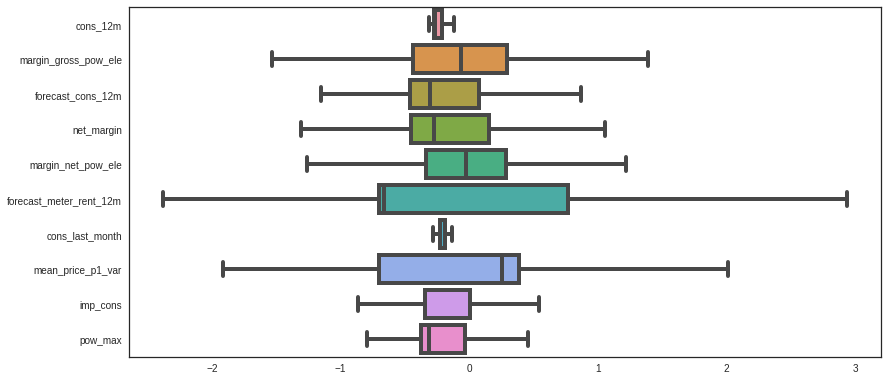

In [242]:
# Get initial feature importances

scaled_data = pd.DataFrame(data=StandardScaler().fit_transform(model_data_train), 
                           index=model_data_train.index, 
                           columns=model_data_train.columns)

rfc = RandomForestClassifier()
rfc.fit(scaled_data, target)

feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = scaled_data.columns,
                                   columns=['importance']).sort_values('importance',ascending=False)

print(feature_importances.head(10),'\n')

# feature = 'forecast_meter_rent_12m'
features = list(feature_importances.index)[:10]

plt.figure(figsize=(12,6))
sns.boxplot(scaled_data[features], 
            showfliers=False, 
            vert=False);

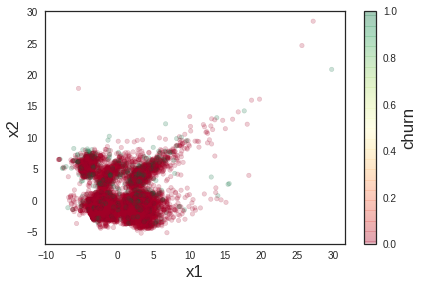

In [243]:
pca_2d = PCA(n_components=2,random_state=42)
twodim_pca_data = pd.DataFrame(data=pca_2d.fit_transform(scaled_data),
                               index=scaled_data.index,
                               columns=['x1','x2'])
two_dim_viz_df = pd.concat([twodim_pca_data,target], axis=1)

two_dim_viz_df.plot.scatter('x1','x2',c='churn',alpha=0.2,cmap='RdYlGn');

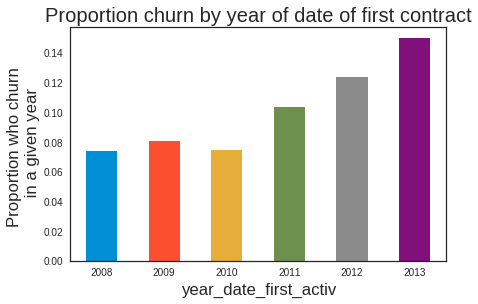

In [244]:
viz_data = pd.concat([model_data_train,target], axis=1).groupby('year_date_first_activ')['churn'].mean().loc[2008:2013]

viz_data.plot(kind='bar',
              title='Proportion churn by year of date of first contract',
              rot=0);
plt.ylabel('Proportion who churn \n in a given year');

# MODELLING

In [0]:
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(model_data_train, 
                                                    target, 
                                                    test_size=0.2, 
                                                    random_state=42)

# withold 25% of training set for validation of hyperparameters
validation_threshold = round(len(X_train)*3/4)
X_val = X_train.iloc[validation_threshold:]
y_val = y_train[validation_threshold:]

# make X_train & y_train exclude validation data
X_train = X_train.iloc[:validation_threshold]
y_train = y_train[:validation_threshold]

## Basic Models

Basic logreg training roc_auc_score: 0.6221212283379558
Basic logreg test roc_auc_score: 0.6090502530304813


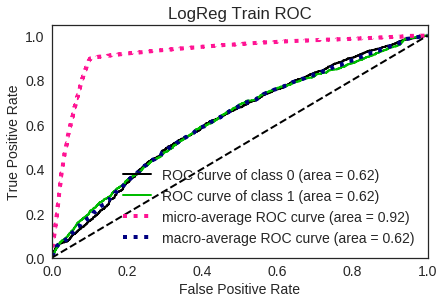

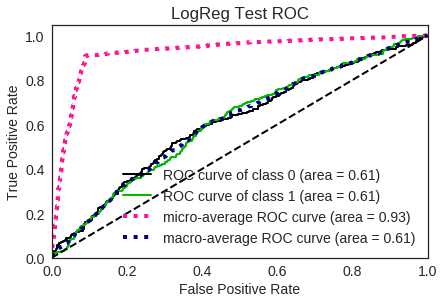

In [246]:
# no optimisation, just to see basic accuracy
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train,y_train)
# print('\n')

probs_train = logreg.predict_proba(X_train)
probs_test = logreg.predict_proba(X_test)

print('Basic logreg training roc_auc_score:', roc_auc_score(y_train,probs_train[:,1]))
print('Basic logreg test roc_auc_score:', roc_auc_score(y_test,probs_test[:,1]))

skplt.metrics.plot_roc(y_train,probs_train, title='LogReg Train ROC');
skplt.metrics.plot_roc(y_test,probs_test, title='LogReg Test ROC');

Basic RandomForest training roc_auc_score: 0.8877980566982484
Basic RandomForest test roc_auc_score: 0.6853507120160056


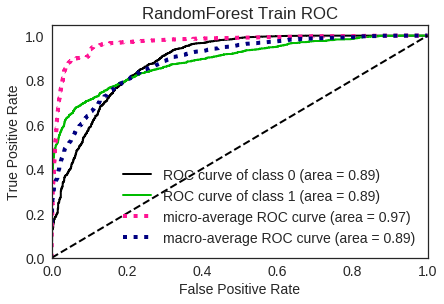

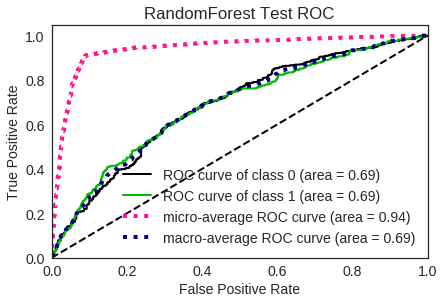

In [247]:
# no optimisation, just to see basic accuracy
forest = RandomForestClassifier(random_state=42,
                                n_estimators=100,
                                max_depth=10)
forest.fit(X_train,y_train)
# print('\n')

probs_train = forest.predict_proba(X_train)
probs_test = forest.predict_proba(X_test)

print('Basic RandomForest training roc_auc_score:', roc_auc_score(y_train,probs_train[:,1]))
print('Basic RandomForest test roc_auc_score:', roc_auc_score(y_test,probs_test[:,1]))

skplt.metrics.plot_roc(y_train,probs_train, title='RandomForest Train ROC');
skplt.metrics.plot_roc(y_test,probs_test, title='RandomForest Test ROC');

## Feature Scaling & Selection

In [0]:
features_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('polyFeat', PolynomialFeatures(degree=2, 
                                    include_bias=False)),
    ('pca', PCA(n_components=50, 
                random_state=42))
])

X_train = features_pipe.fit_transform(X_train)
X_val = features_pipe.transform(X_val)
X_test = features_pipe.transform(X_test)

## K-Nearest Neighbors

In [0]:
# neighbors_params = [1,2,4,7,11,16,22,29,37,46,56,67]
# knn_train_scores = []
# knn_val_scores = []

# for k in neighbors_params:
#   knn = KNeighborsClassifier(n_neighbors=k)
#   knn.fit(X_train,y_train)
#   # print('\n')
  
#   probs_train = knn.predict_proba(X_train)
#   probs_val = knn.predict_proba(X_val)
  
#   knn_train_scores.append(roc_auc_score(y_train,probs_train[:,1]))
#   knn_val_scores.append(roc_auc_score(y_val,probs_val[:,1]))

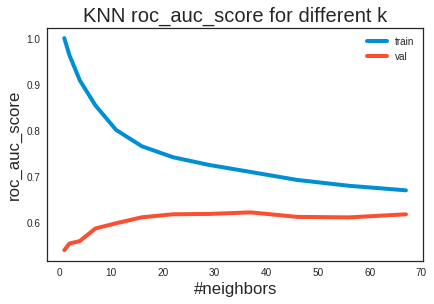

In [250]:
knn_scores_df = pd.DataFrame(data={'train':knn_train_scores,
                                   'val':knn_val_scores},
                             index=neighbors_params)
knn_scores_df.plot(title='KNN roc_auc_score for different k');
plt.xlabel('#neighbors');
plt.ylabel('roc_auc_score');

## Random Forest

In [0]:
# tree_estimators_params = [int(round(n)) for n in np.logspace(0,3,num=4)]
# tree_depth_params = [int(round(depth)) for depth in np.logspace(0.5,2,num=4)]

# tree_scores_df = pd.DataFrame(columns=['n_estimators',
#                                        'max_depth',
#                                        'train_score',
#                                        'val_score'])

# for n in tree_estimators_params:
#   for depth in tree_depth_params:
#     forest = RandomForestClassifier(random_state=42,
#                                     n_estimators=n,
#                                     max_depth=depth)
#     forest.fit(X_train,y_train)

#     probs_train = forest.predict_proba(X_train)
#     probs_val = forest.predict_proba(X_val)
    
#     tree_scores_df = tree_scores_df.append(
#       {'n_estimators':n,
#        'max_depth':depth,
#        'train_score':roc_auc_score(y_train,probs_train[:,1]),
#        'val_score':roc_auc_score(y_val,probs_val[:,1])
#       },
#       ignore_index=True
#     )

Text(0.5,1,'Validation score for two key hyperparams \n for Random Forest')

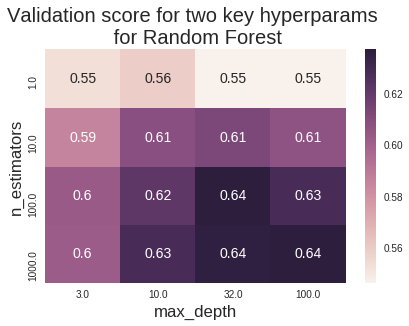

In [252]:
sns.heatmap(tree_scores_df.pivot_table(values='val_score',index='n_estimators',columns='max_depth'),
            annot=True);
plt.title('Validation score for two key hyperparams \n for Random Forest')

## Class Imbalance

In [309]:
# tree_weighting_params = [i**2 for i in range(1,13)]

# tree_weighting_scores_df = pd.DataFrame(columns=['weighting',
#                                                  'train_score',
#                                                  'val_score',
#                                                  'val_recall'])

# for weight in tree_weighting_params:
#   forest = RandomForestClassifier(random_state=42,
#                                   n_estimators=100,
#                                   max_depth=32,
#                                   class_weight={1:weight})
#   forest.fit(X_train,y_train)

#   probs_train = forest.predict_proba(X_train)
#   probs_val = forest.predict_proba(X_val)

#   tree_weighting_scores_df = tree_weighting_scores_df.append(
#     {'weighting':weight,
#      'train_score':roc_auc_score(y_train,probs_train[:,1]),
#      'val_score':roc_auc_score(y_val,probs_val[:,1]),
#      'val_recall':recall_score(y_val,forest.predict(X_val))
#     },
#     ignore_index=True
#   )

RandomForestClassifier(bootstrap=True, class_weight={1: 1}, criterion='gini',
            max_depth=32, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight={1: 4}, criterion='gini',
            max_depth=32, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight={1: 9}, criterion='gini',
            max_depth=32, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight={1: 16}, criterion='gini',
            max_depth=32, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight={1: 25}, criterion='gini',
            max_depth=32, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight={1: 36}, criterion='gini',
            max_depth=32, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight={1: 49}, criterion='gini',
            max_depth=32, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight={1: 64}, criterion='gini',
            max_depth=32, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight={1: 81}, criterion='gini',
            max_depth=32, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight={1: 100},
            criterion='gini', max_depth=32, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight={1: 121},
            criterion='gini', max_depth=32, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight={1: 144},
            criterion='gini', max_depth=32, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

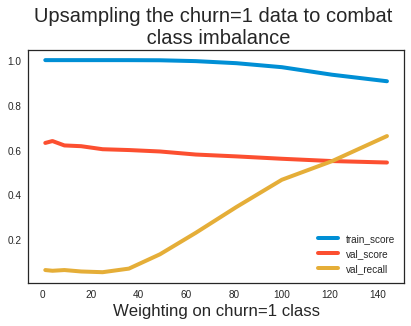

In [314]:
tree_weighting_scores_df.set_index('weighting').plot(title='Upsampling the churn=1 data to combat \n class imbalance');
plt.xlabel('Weighting on churn=1 class');

# Submission

In [318]:
forest = RandomForestClassifier(random_state=42,
                                n_estimators=100,
                                max_depth=32,
                                class_weight={1:5})

forest.fit(X_train,y_train)
probs_test = forest.predict_proba(X_test)
print('\n', 'Final test roc_auc_score:', roc_auc_score(y_test,probs_test[:,1]))

RandomForestClassifier(bootstrap=True, class_weight={1: 5}, criterion='gini',
            max_depth=32, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

Final test roc_auc_score: 0.6285141814758151


In [319]:
X_model = features_pipe.fit_transform(model_data_train)
X_submission = features_pipe.transform(model_data_submission)

forest = RandomForestClassifier(random_state=42,
                                n_estimators=100,
                                max_depth=32,
                                class_weight={1:5})

forest.fit(X_model,target)

submission_df = pd.DataFrame(
    data={'Churn_prediction':forest.predict(X_submission),
          'Churn_probability':forest.predict_proba(X_submission)[:,1]
         },
    index=model_data_submission.index
)


RandomForestClassifier(bootstrap=True, class_weight={1: 5}, criterion='gini',
            max_depth=32, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [321]:
submission_df.head()

,Churn_prediction,Churn_probability
000381698491fec6983d55828fe5ada6,0,0.08
000861c9aa2a0784b8d83f8b5b95d010,0,0.14
0032d340d01dce810b28c3e2a5446fcc,0,0.11
004a743cb630d0540d8016fc6c898786,0,0.09
007d5d9fbd142235658fe836cfd338fa,0,0.12


In [0]:
# submission_df.to_csv('Powerco_submission_RichardCartwright.csv', index=True)

# from google.colab import files
# files.download('Powerco_submission_RichardCartwright.csv')